# This notebook is slow to run
## this is because the top level function can't be decorated for reproducibility: tf.random.set_seed doesn't do anything when inside a graph.

In [1]:
import gc
import os, sys
# add to path
sys.path.append("../..")

import attr
import datetime

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn

import tensorflow as tf
import tensorflow_probability as tfp
import tqdm

# tf.function = lambda x: x
tfd = tfp.distributions

seaborn.set()
tf.random.set_seed(50)

In [2]:
tf.config.set_visible_devices([], 'GPU') 

In [3]:
%load_ext tensorboard
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [4]:
from filterflow.smc import SMC
from filterflow.base import State, StateSeries, DTYPE_TO_OBSERVATION_SERIES

from filterflow.observation.linear import LinearObservationSampler

from filterflow.transition.random_walk import RandomWalkModel
from filterflow.proposal import BootstrapProposalModel
from filterflow.proposal.auxiliary_proposal import AuxiliaryProposal

from filterflow.resampling.criterion import NeffCriterion, AlwaysResample, NeverResample
from filterflow.resampling.standard import SystematicResampler, MultinomialResampler
from filterflow.resampling.differentiable import RegularisedTransform, CorrectedRegularizedTransform
from filterflow.resampling.differentiable.ricatti.solver import PetkovSolver

from filterflow.resampling.base import NoResampling

from filterflow.state_space_model import StateSpaceModel

## Set the State Space Model

In [5]:
tf.random.set_seed(0)
observation_dim = 2
state_dim = 2
T = 150
initial_state          = tf.random.uniform([state_dim], -1., 1.)

transition_matrix      = tf.eye(state_dim) * 0.5
transition_covariance  = tf.eye(state_dim) * 0.5

chol_transition_covariance = tf.linalg.cholesky(transition_covariance)

observation_matrix     = tf.eye(observation_dim) * 0.5
observation_covariance = tf.eye(observation_dim) * 0.1

chol_observation_covariance = tf.linalg.cholesky(observation_covariance)

In [6]:
# Transition
zeros = tf.zeros(state_dim, dtype=float)

transition_noise = tfd.MultivariateNormalTriL(zeros, chol_transition_covariance)
transition_model = RandomWalkModel(transition_matrix, transition_noise)

# Observation
observation_error = tfp.distributions.MultivariateNormalTriL(zeros, chol_observation_covariance)
observation_model = LinearObservationSampler(observation_matrix, observation_error)

In [7]:
## State space model
ss_model = StateSpaceModel(observation_model=observation_model, transition_model=transition_model)
states, observations = ss_model(initial_state, T)

In [8]:
np_obs = np.array([observations[t].numpy().squeeze() for t in range(T)])
np_states = np.array([states[t].particles.numpy().squeeze() for t in range(T)])

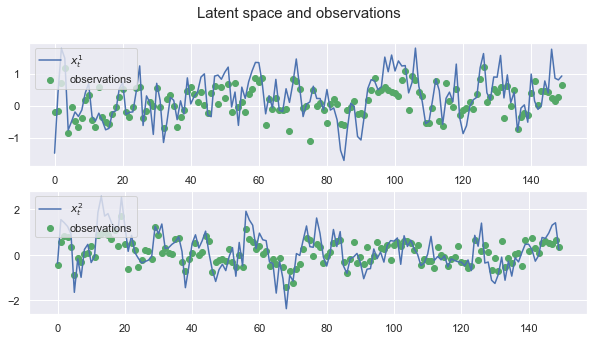

In [9]:
linspace  = np.arange(np_obs[:,0].shape[0])
fig, axes = plt.subplots(nrows=2, figsize=(10, 5))
axes[0].scatter(linspace, np_obs[:,0], marker='o', color='g', label='observations')
axes[0].plot(np_states[:, 0], color='b', label='$x^1_t$')
axes[1].plot(np_states[:, 1], color='b', label='$x^2_t$')
axes[1].scatter(linspace, np_obs[:,1], marker='o', color='g', label='observations')
_ = axes[0].legend(loc='upper left')
_ = axes[1].legend(loc='upper left')
_ = fig.suptitle('Latent space and observations', fontsize=15)

In [10]:
obs_data = tf.data.Dataset.from_tensor_slices(observations)

### Set up the filter

In [11]:
# store observations
batch_size = 1
n_particles = 25
dimension = 2

initial_weights = tf.ones((batch_size, n_particles), dtype=float) / tf.cast(n_particles, float)
initial_particles = tf.random.uniform((batch_size, n_particles, dimension), -1, 1)
log_likelihoods = tf.zeros(batch_size, dtype=float)
initial_state = State(particles=initial_particles, 
                      log_weights = tf.math.log(initial_weights),
                      weights=initial_weights, 
                      log_likelihoods=log_likelihoods, 
                      ancestor_indices=None, 
                      resampling_correction=None)


modifiable_transition_matrix = tf.Variable(tf.linalg.diag([0., 0.]))
modifiable_transition_model = RandomWalkModel(modifiable_transition_matrix, transition_noise)
modifiable_proposal_model = BootstrapProposalModel(modifiable_transition_model)


In [12]:
resampling_criterion = NeffCriterion(tf.constant(0.5), tf.constant(True))
systematic = SystematicResampler()

epsilon = tf.constant(0.5)
scaling = tf.constant(0.9)
convergence_threshold=tf.constant(1e-5)
max_iter=tf.constant(500)

regularized = RegularisedTransform(epsilon, scaling=scaling, max_iter=max_iter, convergence_threshold=convergence_threshold)


solver = PetkovSolver(tf.constant(50))

corrected = CorrectedRegularizedTransform(epsilon, scaling=scaling, max_iter=max_iter, convergence_threshold=convergence_threshold, ricatti_solver=solver, propagate_correction_gradient=tf.constant(False))
propagated_corrected = CorrectedRegularizedTransform(epsilon, scaling=scaling, max_iter=max_iter, convergence_threshold=convergence_threshold, ricatti_solver=solver, propagate_correction_gradient=tf.constant(True))


systematic_smc = SMC(observation_model, modifiable_transition_model, modifiable_proposal_model, resampling_criterion, systematic)
regularized_smc = SMC(observation_model, modifiable_transition_model, modifiable_proposal_model, resampling_criterion, regularized)
corrected_smc = SMC(observation_model, modifiable_transition_model, modifiable_proposal_model, resampling_criterion, corrected)
propagated_corrected_smc = SMC(observation_model, modifiable_transition_model, modifiable_proposal_model, resampling_criterion, propagated_corrected)


In [13]:
mesh_size = 20
x_linspace = np.linspace(0., 0.85, mesh_size).astype(np.float32)
y_linspace = np.linspace(0.3, 0.8, mesh_size).astype(np.float32)
mesh = np.asanyarray([(x, y) for x in x_linspace for y in y_linspace])

In [14]:
@tf.function
def get_res(smc, use_correction_term):
    with tf.GradientTape() as tape:
        tape.watch(modifiable_transition_matrix)
        final_state = smc(initial_state, observation_series=obs_data, n_observations=T, return_final=True)
        ll = tf.reduce_mean(final_state.log_likelihoods, keepdims=True)
        if use_correction_term:
            correction_term = final_state.resampling_correction
            corrected_ll = ll + correction_term
        else:
            corrected_ll = ll
    ll_grad = tf.linalg.diag_part(tape.gradient(corrected_ll, modifiable_transition_matrix))
    return ll, ll_grad

In [15]:
# do not decorate this function - tensorflow is stateful and has complicated behaviour around local vs global seeds: tf.random.set_seed doesn't work within a function graph
def get_surface(mesh_dataset, smc, use_correction_term):
    array = tf.TensorArray(size=mesh_size**2, dtype=tf.float32, dynamic_size=False, element_shape=[3])
    for i, val in enumerate(tqdm.tqdm(mesh_dataset)):
        tf_val = tf.constant(val)
        transition_matrix = tf.linalg.diag(tf_val)
        assign_op = modifiable_transition_matrix.assign(transition_matrix)
        tf.random.set_seed(0)
        with tf.control_dependencies([assign_op]):
            ll, ll_grad = get_res(smc, use_correction_term)
        array = array.write(tf.cast(i, tf.int32), tf.concat([ll, ll_grad], 0))
    gc.collect()
    return array.stack()
        

In [16]:
corrected_systematic_data = get_surface(mesh, systematic_smc, True).numpy()

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [08:12<00:00,  1.23s/it]


In [17]:
systematic_data = get_surface(mesh, systematic_smc, False).numpy()

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [08:08<00:00,  1.22s/it]


In [19]:
regularized_data = get_surface(mesh, regularized_smc, False).numpy()

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [19:21<00:00,  2.90s/it]


In [20]:
corrected_data = get_surface(mesh, corrected_smc, False).numpy()

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [41:16<00:00,  6.19s/it]


In [21]:
propagated_corrected_data = get_surface(mesh, propagated_corrected_smc, False).numpy()

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [41:27<00:00,  6.22s/it]


In [22]:
import pykalman

kf_res = []
kf_res_grad = []
eps = 1e-5

for val in tqdm.tqdm(mesh):
    a_val, b_val = val
    transition_matrix_np_a_eps = np.diag([a_val+eps, b_val])
    transition_matrix_np_b_eps = np.diag([a_val, b_val+eps])
    transition_matrix_np = np.diag([a_val, b_val])
    
    kf_a_eps = pykalman.KalmanFilter(transition_matrix_np_a_eps, 
                                     observation_matrix.numpy(), 
                                     transition_covariance.numpy(), 
                                     observation_covariance.numpy(), 
                                     initial_state_mean=[0., 0.], 
                                     initial_state_covariance=np.eye(2))
    
    kf_b_eps = pykalman.KalmanFilter(transition_matrix_np_b_eps, 
                                     observation_matrix.numpy(), 
                                     transition_covariance.numpy(), 
                                     observation_covariance.numpy(), 
                                     initial_state_mean=[0., 0.], 
                                     initial_state_covariance=np.eye(2))
    
    kf = pykalman.KalmanFilter(transition_matrix_np, 
                               observation_matrix.numpy(), 
                               transition_covariance.numpy(), 
                               observation_covariance.numpy(), 
                               initial_state_mean=[0., 0.], 
                               initial_state_covariance=np.eye(2))
    
    ll = kf.loglikelihood(np_obs)
    ll_a_eps = kf_a_eps.loglikelihood(np_obs)
    ll_b_eps = kf_b_eps.loglikelihood(np_obs)
    
    kf_res.append(ll)
    kf_res_grad.append([(ll_a_eps-ll)/eps, (ll_b_eps-ll)/eps])
kf_res = np.asanyarray(kf_res)
kf_res_grad = np.asanyarray(kf_res_grad)

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:29<00:00,  4.47it/s]


In [23]:
mask = mesh[:, 0] < 0.6
mesh_mask = mesh[mask]
x_mask_size = len(np.unique(mesh_mask[:, 0]))
y_mask_size = len(np.unique(mesh_mask[:, 1]))
kf_res_mask = kf_res[mask]
kf_res_grad_mask = kf_res_grad[mask]
systematic_data_mask = systematic_data[mask]
regularized_data_mask = regularized_data[mask]
corrected_data_mask = corrected_data[mask]

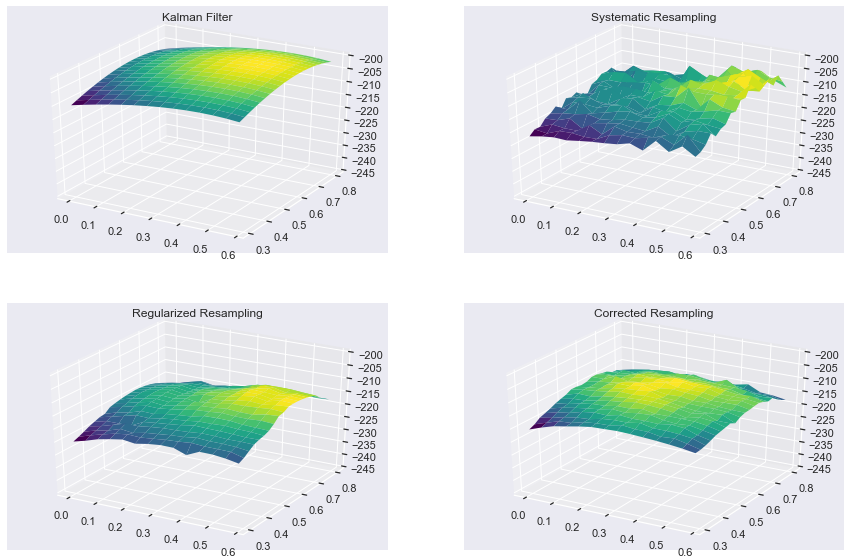

In [24]:
fig = plt.figure(figsize=(15, 10))

X = mesh_mask[:, 0].reshape([x_mask_size, y_mask_size])
Y = mesh_mask[:, 1].reshape([x_mask_size, y_mask_size])

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.plot_surface(X, Y, kf_res_mask.reshape([x_mask_size, y_mask_size]), cmap='viridis', edgecolor='none')
ax.set_title('Kalman Filter')

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.plot_surface(X, Y, systematic_data_mask[:, 0].reshape([x_mask_size, y_mask_size]), cmap='viridis', edgecolor='none')
ax.set_title('Systematic Resampling')

ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.plot_surface(X, Y, regularized_data_mask[:, 0].reshape([x_mask_size, y_mask_size]), cmap='viridis', edgecolor='none')
ax.set_title('Regularized Resampling')

ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.plot_surface(X, Y, corrected_data_mask[:, 0].reshape([x_mask_size, y_mask_size]), cmap='viridis', edgecolor='none')
ax.set_title('Corrected Resampling')

for ax in fig.get_axes():
    ax.set_zlim(-245, -200)


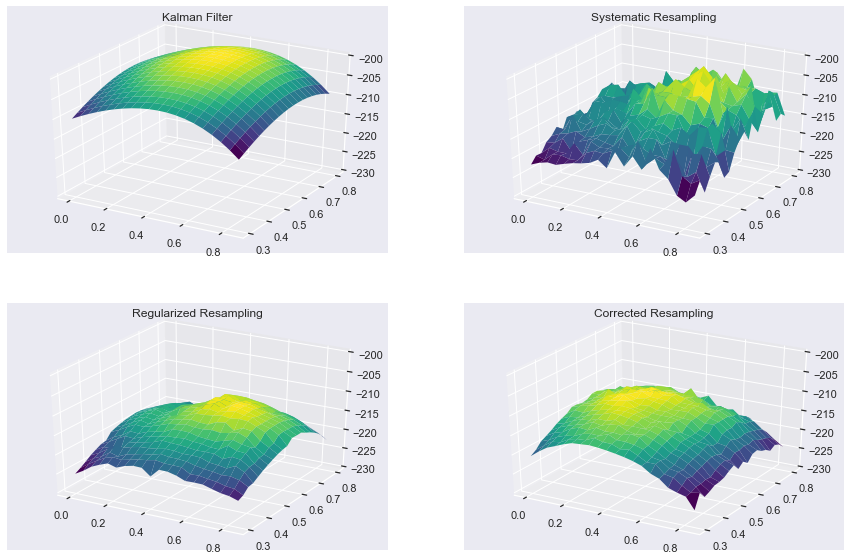

In [25]:
fig = plt.figure(figsize=(15, 10))

X = mesh[:, 0].reshape([mesh_size, mesh_size])
Y = mesh[:, 1].reshape([mesh_size, mesh_size])

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.plot_surface(X, Y, kf_res.reshape([mesh_size, mesh_size]), cmap='viridis', edgecolor='none')
ax.set_title('Kalman Filter')

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.plot_surface(X, Y, systematic_data[:, 0].reshape([mesh_size, mesh_size]), cmap='viridis', edgecolor='none')
ax.set_title('Systematic Resampling')

ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.plot_surface(X, Y, regularized_data[:, 0].reshape([mesh_size, mesh_size]), cmap='viridis', edgecolor='none')
ax.set_title('Regularized Resampling')

ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.plot_surface(X, Y, corrected_data[:, 0].reshape([mesh_size, mesh_size]), cmap='viridis', edgecolor='none')
ax.set_title('Corrected Resampling')

for ax in fig.get_axes():
    ax.set_zlim(-230, -200)


Text(0.5, 1.0, 'Corrected Resampling')

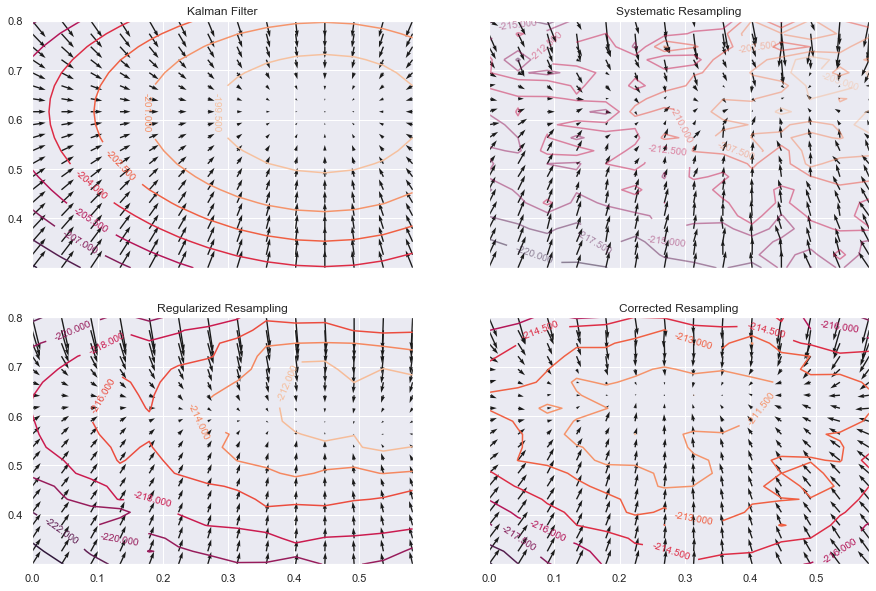

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

X = mesh_mask[:, 0].reshape([x_mask_size, y_mask_size])
Y = mesh_mask[:, 1].reshape([x_mask_size, y_mask_size])


contour = axes[0, 0].contour(X, Y, kf_res_mask.reshape([x_mask_size, y_mask_size]))
axes[0, 0].clabel(contour, inline=1, fontsize=10)
axes[0, 0].quiver(mesh_mask[:, 0], mesh_mask[:, 1], kf_res_grad_mask[:, 0], kf_res_grad_mask[:, 1])
axes[0, 0].set_title('Kalman Filter')

contour = axes[0, 1].contour(X, Y, systematic_data_mask[:, 0].reshape([x_mask_size, y_mask_size]), alpha=0.5)
axes[0, 1].clabel(contour, inline=1, fontsize=10)
axes[0, 1].quiver(mesh_mask[:, 0], mesh_mask[:, 1], systematic_data_mask[:, 1], systematic_data_mask[:, 2])
axes[0, 1].set_title('Systematic Resampling')

contour = axes[1, 0].contour(X, Y, regularized_data_mask[:, 0].reshape([x_mask_size, y_mask_size]))
axes[1, 0].clabel(contour, inline=1, fontsize=10)
axes[1, 0].quiver(mesh_mask[:, 0], mesh_mask[:, 1], regularized_data_mask[:, 1], regularized_data_mask[:, 2])
axes[1, 0].set_title('Regularized Resampling')

contour = axes[1, 1].contour(X, Y, corrected_data_mask[:, 0].reshape([x_mask_size, y_mask_size]))
axes[1, 1].clabel(contour, inline=1, fontsize=10)
axes[1, 1].quiver(mesh_mask[:, 0], mesh_mask[:, 1], corrected_data_mask[:, 1], corrected_data_mask[:, 2])
axes[1, 1].set_title('Corrected Resampling')



Text(0.5, 1.0, 'Corrected Resampling')

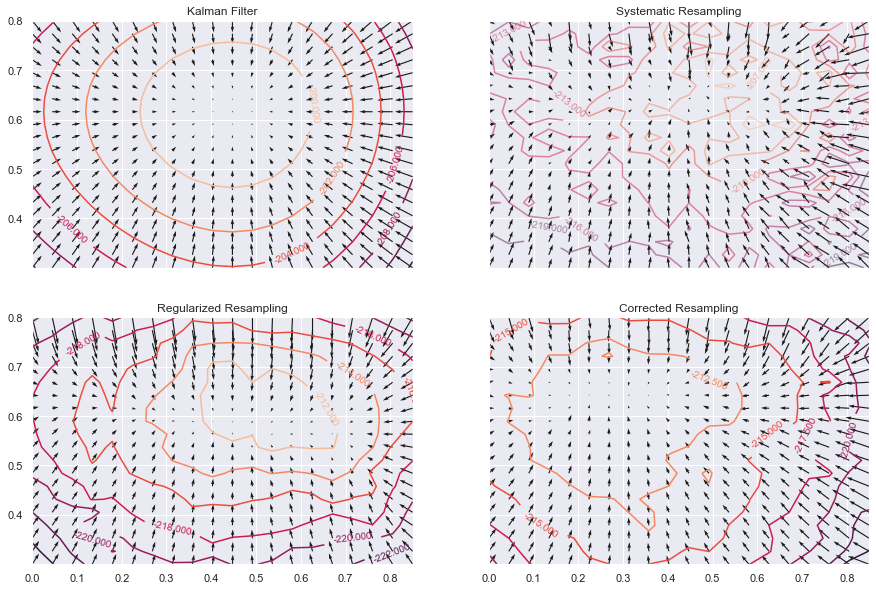

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

X = mesh[:, 0].reshape([mesh_size, mesh_size])
Y = mesh[:, 1].reshape([mesh_size, mesh_size])

contour = axes[0, 0].contour(X, Y, kf_res.reshape([mesh_size, mesh_size]))
axes[0, 0].clabel(contour, inline=1, fontsize=10)
axes[0, 0].quiver(mesh[:, 0], mesh[:, 1], kf_res_grad[:, 0], kf_res_grad[:, 1])
axes[0, 0].set_title('Kalman Filter')

contour = axes[0, 1].contour(X, Y, systematic_data[:, 0].reshape([mesh_size, mesh_size]), alpha=0.5)
axes[0, 1].clabel(contour, inline=1, fontsize=10)
axes[0, 1].quiver(mesh[:, 0], mesh[:, 1], systematic_data[:, 1], systematic_data[:, 2])
axes[0, 1].set_title('Systematic Resampling')

contour = axes[1, 0].contour(X, Y, regularized_data[:, 0].reshape([mesh_size, mesh_size]))
axes[1, 0].clabel(contour, inline=1, fontsize=10)
axes[1, 0].quiver(mesh[:, 0], mesh[:, 1], regularized_data[:, 1], regularized_data[:, 2])
axes[1, 0].set_title('Regularized Resampling')

contour = axes[1, 1].contour(X, Y, propagated_corrected_data[:, 0].reshape([mesh_size, mesh_size]))
axes[1, 1].clabel(contour, inline=1, fontsize=10)
axes[1, 1].quiver(mesh[:, 0], mesh[:, 1], propagated_corrected_data[:, 1], corrected_data[:, 2])
axes[1, 1].set_title('Corrected Resampling')



Text(0.5, 1.0, 'Systematic')

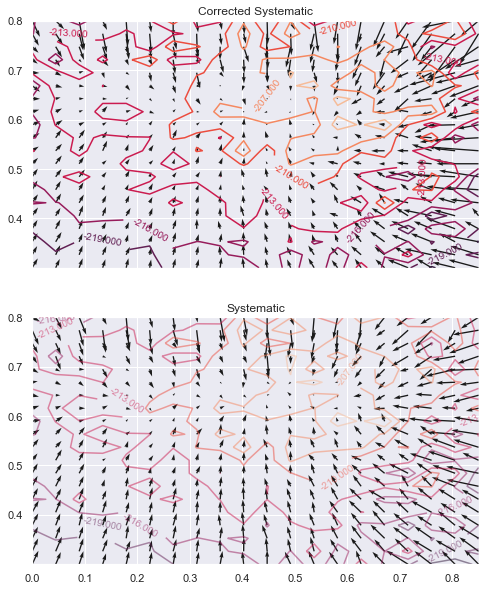

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True, sharey=True)

X = mesh[:, 0].reshape([mesh_size, mesh_size])
Y = mesh[:, 1].reshape([mesh_size, mesh_size])

contour = axes[0].contour(X, Y, corrected_systematic_data[:, 0].reshape([mesh_size, mesh_size]))
axes[0].clabel(contour, inline=1, fontsize=10)
axes[0].quiver(mesh[:, 0], mesh[:, 1], corrected_systematic_data[:, 1], corrected_systematic_data[:, 2])
axes[0].set_title('Corrected Systematic')

contour = axes[1].contour(X, Y, systematic_data[:, 0].reshape([mesh_size, mesh_size]), alpha=0.5)
axes[1].clabel(contour, inline=1, fontsize=10)
axes[1].quiver(mesh[:, 0], mesh[:, 1], systematic_data[:, 1], systematic_data[:, 2])
axes[1].set_title('Systematic')


